# Comparing new momentum distributions code to old LDA code

__Author:__ A. J. Tropiano [atropiano@anl.gov]<br/>
__Date:__ February 15, 2023

This notebook compares the old LDA momentum distributions code to the new code which uses single-particle wave functions and `vegas` to integrate over momenta. There are differences in how each calculation is implemented, but the SRG transformations are unitary; therefore, the normalization of the momentum distribution should give $Z$ (or $N$).

_Last update:_ February 22, 2023

In [1]:
# Python imports
import functools
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import numpy.linalg as la
from numpy.polynomial.legendre import leggauss
from scipy.interpolate import RectBivariateSpline, RegularGridInterpolator
import time
import vegas

In [2]:
# Imports from scripts
from scripts.figures import set_rc_parameters
from scripts.integration import (
    gaussian_quadrature_mesh, unattach_weights_from_matrix
)
from scripts.potentials import Potential
from scripts.srg import get_transformation
from scripts.tools import channel_L_value, coupled_channel

## Set-up

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

## Compare the $|\mathbf{q}-\frac{\mathbf{K}}{2}|$ dependence

In [4]:
def f1(q_array, K_array, K_weights, x_array, x_weights):
    """Computes 4\pi \int_0^\infty dK K^2 \int_{-1}^1 dx/2 |q-K\2|."""
    
    q_grid, K_grid, x_grid = np.meshgrid(q_array, K_array, x_array,
                                         indexing='ij')
    
    _, dK_grid, dx_grid = np.meshgrid(q_array, K_weights, x_weights,
                                      indexing='ij')
    
    qK_norm_grid = np.sqrt(q_grid**2 + K_grid**2/4 - q_grid * K_grid * x_grid)
    
    integrand_K_x = qK_norm_grid * K_grid**2 * dK_grid * dx_grid/2
    
    # integrate over x
    integrand_K = np.sum(integrand_K_x, axis=-1)
    
    # integrate over K
    return 4*np.pi*np.sum(integrand_K, axis=-1)

In [5]:
def f2_integrand(q, momenta_array):
    """Integrand of f_2(q)."""
    
    # Choose z-axis to be along q_vector
    q_vector = np.array([0, 0, q])

    # C.o.M. momenta K
    K, theta, phi = momenta_array
    K_vector = np.array([K * np.sin(theta) * np.cos(phi),
                         K * np.sin(theta) * np.sin(phi),
                         K * np.cos(theta)])
    
    # Calculate vector q-K/2
    qK_vector = q_vector - K_vector/2
    qK = la.norm(qK_vector)
        
    # Calculate the Jacobian determinant
    jacobian = K**2 * np.sin(theta)
    
    return qK * jacobian

In [6]:
def f2(q_array):
    """Computes \int_0^\infty dK K^2 \int_0^\pi sin(\theta) d\theta
    \int_0^{2\pi} d\phi |q-K\2|, where the z-axis is along q_vector using vegas.
    """

    # Set-up integration with vegas
    K_limits = [0, 2.7]  # C.o.M. momenta up to 3 fm^-1
    theta_limits = [0, np.pi]
    phi_limits = [0, 2*np.pi]

    # Set-up integrator with multiple processors
    integ = vegas.Integrator([K_limits, theta_limits, phi_limits])

    # Loop over q_vector
    func_q_array = np.zeros_like(q_array)
    t0 = time.time()
    for iq, q in enumerate(q_array):
        
        integrand = functools.partial(f2_integrand, q)
        
        # Train the integrator
        integ(integrand, nitn=5, neval=1e3)
        # Final result
        result = integ(integrand, nitn=10, neval=3e3)

        func_q_array[iq] = result.mean

    t1 = time.time()
    mins = (t1-t0)/60
    print(f"Done after {mins:.3f} minutes.")
                    
    return func_q_array

In [7]:
def f3(q_array, K_array, K_weights):
    """Computes \int_0^\infty dK K^2 \int_0^\pi sin(\theta) d\theta 
    \int_0^{2\pi} d\phi |q-K\2|, where the z-axis is along q_vector using
    Gaussian quadrature.
    """
    
    theta_array, theta_weights = gaussian_quadrature_mesh(np.pi, 9)
    phi_array, phi_weights = gaussian_quadrature_mesh(2*np.pi, 17)
    
    func_q_array = np.zeros_like(q_array)
    for iq, q in enumerate(q_array):
        
        q_vector = np.array([0, 0, q])
        
        value = 0
        for iK, K in enumerate(K_array):
            for it, t in enumerate(theta_array):
                for ip, p in enumerate(phi_array):
                    
                    K_vector = np.array([K*np.sin(t)*np.cos(p),
                                         K*np.sin(t)*np.sin(p),
                                         K*np.cos(t)])
                    
                    qK_norm = la.norm(q_vector - K_vector/2)
                    dK = K_weights[iK]
                    dt = theta_weights[it]
                    dp = phi_weights[ip]
                    
                    value += qK_norm * K**2 * dK * np.sin(t) * dt * dp
                    
        func_q_array[iq] = value
        
    return func_q_array

Done after 0.160 minutes.


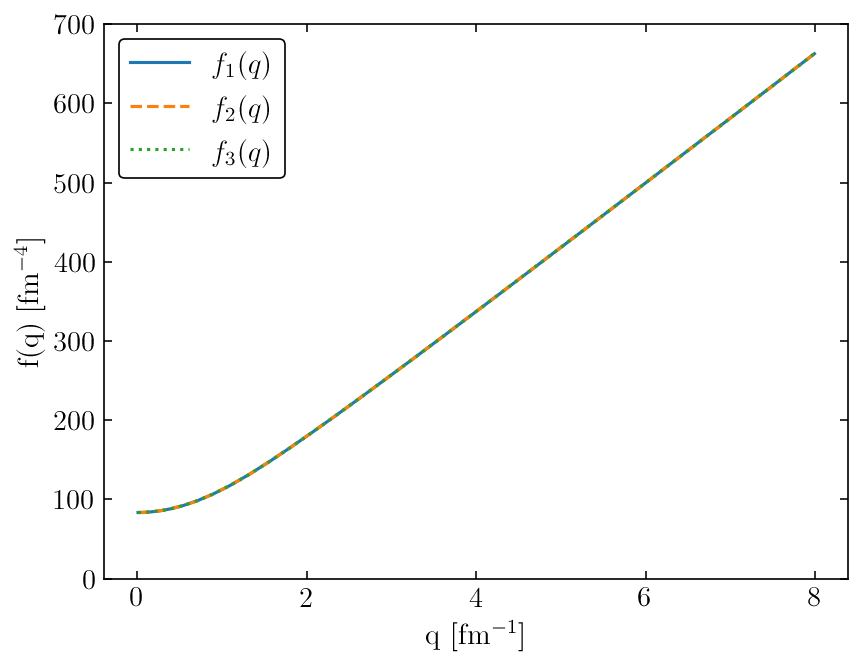

In [8]:
x_array, x_weights = leggauss(7)  # Angles between q and K for angle-averaging
K_array, K_weights = gaussian_quadrature_mesh(2.7, 40)
q_array, _ = gaussian_quadrature_mesh(8.0, 40)

f1_array = f1(q_array, K_array, K_weights, x_array, x_weights)
f2_array = f2(q_array)
f3_array = f3(q_array, K_array, K_weights)

plt.plot(q_array, f1_array, label=r'$f_1(q)$', linestyle='-')
plt.plot(q_array, f2_array, label=r'$f_2(q)$', linestyle='--')
plt.plot(q_array, f3_array, label=r'$f_3(q)$', linestyle=':')
plt.ylim((0.0, 700.0))
plt.xlabel(r'q [fm$^{-1}$]')
plt.ylabel(r'f(q) [fm$^{-4}$]')
plt.legend(loc='upper left')
plt.show()

Showing the difference between angle-averaging compared to integrating over all angles of $\mathbf{K}$ (using `vegas` and Gaussian quadrature) to evaluate the vector norm $|\mathbf{q}-\frac{\mathbf{K}}{2}|$.

$$
f_1(q) = 4\pi \int_0^\infty dK K^2 \int_{-1}^{1} \frac{dx}{2}\, |\mathbf{q}-\frac{\mathbf{K}}{2}|,
$$
where $|\mathbf{q}-\frac{\mathbf{K}}{2}| = \sqrt{q^2+K^2/4-qKx}$.<br>

$$
f_{2,3}(q) = \int_0^\infty dK K^2 \int_0^\pi \sin(\theta) d\theta \int_0^{2\pi} d\phi\,
    |\mathbf{q}-\frac{\mathbf{K}}{2}|,
$$
where $\mathbf{q}=\langle 0,0,q \rangle$ and $\mathbf{K}=\langle K \sin(\theta) \cos(\phi), K \sin(\theta) \sin(\phi), K \cos(\theta) \rangle$.<br>

$f_2(q)$ is evaluated using `vegas` and $f_3(q)$ is evaluated using Gaussian quadrature.

## Compare interpolation of $\delta U$ between codes

### Common arguments

In [9]:
kvnn, kmax, kmid, ntot = 6, 15.0, 3.0, 120
channel = '3S1'
# channel = '3P1'
generator = 'Wegner'
lamb = 1.35

# Set potential
potential = Potential(kvnn, channel, kmax, kmid, ntot)

### Functions from `momentum_distributions.py` (old LDA code)

In [10]:
def get_deltaU_matrix_element(channel, delta_U_matrix, ntot):
    
    # This case corresponds to coupled-channel partial waves
    if coupled_channel(channel):

        # First L of coupled-channel
        deltaU = delta_U_matrix[:ntot, :ntot]
        deltaU_squared = (delta_U_matrix[:ntot, :ntot] ** 2
                          + delta_U_matrix[:ntot, ntot:] ** 2)

    else:

        deltaU = delta_U_matrix
        deltaU_squared = delta_U_matrix ** 2
        
    return deltaU, deltaU_squared

In [11]:
def interpolated_delta_U_lda(potential, channel):
    """
    Function that returns interpolated \delta U(k,k'), \delta U^\dagger(k,k'),
    and \delta U (k, k') \delta U^\dagger(k', k).
    """
    
    # Get momentum mesh
    k_array, k_weights = potential.load_mesh()
    ntot = potential.ntot

    # Initial Hamiltonian
    H_initial = potential.load_hamiltonian()
    # Evolved Hamiltonian
    H_evolved = potential.load_hamiltonian('srg', generator, lamb)

    # Get SRG transformation U(k, k') [unitless]
    U_matrix_unitless = get_transformation(H_initial, H_evolved)
    # Coupled-channel?
    cc_bool = coupled_channel(channel)

    # Isolate 2-body term and convert to fm^3
    if cc_bool:
        I_matrix_unitless = np.eye(2 * ntot, 2 * ntot)
    else:
        I_matrix_unitless = np.eye(ntot, ntot)
    delta_U_matrix_unitless = U_matrix_unitless - I_matrix_unitless
        
    delta_U_matrix = unattach_weights_from_matrix(
        k_array, k_weights, delta_U_matrix_unitless, cc_bool
    )  # fm^3

    deltaU, deltaU2 = get_deltaU_matrix_element(channel, delta_U_matrix, ntot)

    # Interpolate \delta U(k,k')
    deltaU_func = RectBivariateSpline(k_array, k_array, deltaU)
    deltaU_dag_func = RectBivariateSpline(k_array, k_array, deltaU.T)
    deltaU2_func = RectBivariateSpline(k_array, k_array, deltaU2)
#     deltaU_func = RegularGridInterpolator((k_array, k_array), deltaU)
#     deltaU_dag_func = RegularGridInterpolator((k_array, k_array), deltaU)
#     deltaU2_func = RegularGridInterpolator((k_array, k_array), deltaU2)
        
    return deltaU_func, deltaU_dag_func, deltaU2_func

### Functions from `test_momentum_distribution_script.py`

In [12]:
def interpolate_delta_U(
        potential, channel, hermitian_conjugate=False, squared=False
):
    """Function that returns interpolated \delta U(k, k'),
    \delta U^\dagger(k, k') or \delta U^2(k, k') given the partial wave channel.
    """
    
    # Get momentum mesh
    k_array, k_weights = potential.load_mesh()
    ntot = potential.ntot

    # Initial Hamiltonian
    H_initial = potential.load_hamiltonian()
    # Evolved Hamiltonian
    H_evolved = potential.load_hamiltonian('srg', generator, lamb)
    
    # Get SRG transformation from Hamiltonians
    U_matrix_weights = get_transformation(H_initial, H_evolved)
    
    # Calculate \delta U = U - I
    I_matrix_weights = np.eye(len(H_initial), len(H_initial))
    if hermitian_conjugate:
        delU_matrix_weights = (U_matrix_weights - I_matrix_weights).T
    else:
        delU_matrix_weights = U_matrix_weights - I_matrix_weights

    # Get specific sub-block if coupled-channel
    if channel in ['3S1-3D1', '3P2-3F2', '3D3-3G3']:
        delU_matrix = unattach_weights_from_matrix(
            k_array, k_weights, delU_matrix_weights[:ntot,ntot:])
    elif channel in ['3D1-3S1', '3F2-3P2', '3G3-3D3']:
        delU_matrix = unattach_weights_from_matrix(
            k_array, k_weights, delU_matrix_weights[ntot:,:ntot])
    elif channel in ['3D1-3D1', '3F2-3F2', '3G3-3G3']:
        delU_matrix = unattach_weights_from_matrix(
            k_array, k_weights, delU_matrix_weights[ntot:,ntot:])
    else:
        delU_matrix = unattach_weights_from_matrix(
            k_array, k_weights, delU_matrix_weights[:ntot,:ntot])
        
    # Interpolate \delta U^2(k, k') = \delta U(k, k') \delta U^\dagger(k', k)
    if squared:
        delU_func = RectBivariateSpline(k_array, k_array, delU_matrix**2)
    # Interpolate \delta U(k, k') or \delta U^\dagger(k, k')
    else:
        delU_func = RectBivariateSpline(k_array, k_array, delU_matrix)
    
    return delU_func

In [13]:
def get_delta_U_functions(potential, channel):
    
    if channel == '3S1':
        channels = ('3S1-3S1', '3S1-3D1', '3D1-3S1')
    else:
        channels = [channel]

    delta_U_functions = {}
    delta_U_dagger_functions = {}
    delta_U2_functions = {}
    for ichannel in channels:
        delta_U_functions[ichannel] = interpolate_delta_U(potential, ichannel)
        delta_U_dagger_functions[ichannel] = interpolate_delta_U(
            potential, ichannel, hermitian_conjugate=True
        )
        delta_U2_functions[ichannel] = interpolate_delta_U(
            potential, ichannel, squared=True
        )

    return delta_U_functions, delta_U_dagger_functions, delta_U2_functions

### Comparison

In [14]:
# Compare the interpolated functions evaluating at random (k, k') points
k, kp = 1.0, 2.0
# k, kp, = 0.5, 7.5
# k, kp, = 5, 7.5

In [15]:
# LDA
deltaU_func_lda, deltaU_dag_func_lda, deltaU2_func_lda = (
    interpolated_delta_U_lda(potential, channel)
)

deltaU_lda = deltaU_func_lda.ev(k, kp)
deltaU_dag_lda = deltaU_dag_func_lda.ev(k, kp)
deltaU2_lda = deltaU2_func_lda.ev(k, kp)

print("LDA result:\n")
print(f"\delta U(k, k') = {deltaU_lda}.")
print(f"\delta U^\dagger(k, k') = {deltaU_dag_lda}.")
print(f"\delta U(k, k') \delta U^\dagger(k', k) = {deltaU2_lda}.\n")

LDA result:

\delta U(k, k') = 0.017512087396192224.
\delta U^\dagger(k, k') = -0.08402338619235813.
\delta U(k, k') \delta U^\dagger(k', k) = 0.041379927143228246.



In [16]:
# New code
delta_U_functions, delta_U_dagger_functions, delta_U2_functions = (
    get_delta_U_functions(potential, channel)
)

if channel == '3S1':
    
    deltaU = delta_U_functions['3S1-3S1'].ev(k, kp)
    deltaU_dag = delta_U_dagger_functions['3S1-3S1'].ev(k, kp)
    
    # Individually interpolated \delta U and \delta U^\dagger
    deltaU2 = (
        delta_U_functions['3S1-3S1'].ev(k, kp)
        * delta_U_dagger_functions['3S1-3S1'].ev(kp, k)
        + delta_U_functions['3S1-3D1'].ev(k, kp)
        * delta_U_dagger_functions['3D1-3S1'].ev(kp, k)
    )

    # Interpolated \delta U^2
#     deltaU2 = (
#         delta_U2_functions['3S1-3S1'].ev(k, kp)
#         + delta_U2_functions['3S1-3D1'].ev(k, kp)
#     )
    
else:
    
    deltaU = delta_U_functions[channel].ev(k, kp)
    deltaU_dag = delta_U_dagger_functions[channel].ev(k, kp)
    deltaU2 = (
        delta_U_functions[channel].ev(k, kp)
        * delta_U_dagger_functions[channel].ev(kp, k)
    )

print("New code result:\n")
print(f"\delta U(k, k') = {deltaU}.")
print(f"\delta U^\dagger(k, k') = {deltaU_dag}.")
print(f"\delta U(k, k') \delta U^\dagger(k', k) = {deltaU2}.\n")

New code result:

\delta U(k, k') = 0.017512087396192224.
\delta U^\dagger(k, k') = -0.08402338619235815.
\delta U(k, k') \delta U^\dagger(k', k) = 0.041379932644982596.



In [17]:
print(f"Difference in \delta U(k, k') = {abs(deltaU_lda-deltaU)}.")
print(
    f"Difference in \delta U^\dagger(k, k') = {abs(deltaU_dag_lda-deltaU_dag)}."
)
print(
    "Difference in \delta U(k, k') \delta U^\dagger(k', k) ="
    f" {abs(deltaU2_lda-deltaU2)}."
)

Difference in \delta U(k, k') = 0.0.
Difference in \delta U^\dagger(k, k') = 1.3877787807814457e-17.
Difference in \delta U(k, k') \delta U^\dagger(k', k) = 5.501754350711874e-09.


In [18]:
# 3S1-3D1
print(delta_U_functions['3D1-3S1'].ev(k, kp))
print(delta_U_dagger_functions['3S1-3D1'].ev(kp, k))
product = (delta_U_functions['3S1-3D1'].ev(k, kp)
           * delta_U_dagger_functions['3D1-3S1'].ev(kp, k))
print(product)
print(delta_U_functions['3S1-3D1'].ev(k, kp) ** 2)
print(delta_U_functions['3S1-3D1'].ev(k, kp) ** 2 - product)

-0.002223761205278427
-0.002223761205278427
0.04107325944001072
0.04107325944001073
6.938893903907228e-18


In [19]:
# 3S1-3S1
# print(delta_U_dagger_functions['3S1-3S1'].ev(kp, k))
# print(delta_U_functions['3S1-3S1'].ev(k, kp))
# product = (delta_U_functions['3S1-3S1'].ev(k, kp)
#            * delta_U_dagger_functions['3S1-3S1'].ev(kp, k))
# print(product)
# print(delta_U_functions['3S1-3S1'].ev(k, kp) ** 2)
# print(delta_U_functions['3S1-3S1'].ev(k, kp) ** 2 - product)

## Compare integration over momenta of $\delta U^2$ between codes

$$
f_{\rm{LDA}}(q) = (4\pi)^2 \int_0^\infty dk k^2 \int_0^\infty dK K^2 \int_{-1}^1 \frac{dx}{2}
\bigl[
    \delta U_{^{3}S_1-^{3}S_1}(k, |\mathbf{q}-\frac{\mathbf{K}}{2}|)
    \delta U^\dagger_{^{3}S_1-^{3}S_1}(|\mathbf{q}-\frac{\mathbf{K}}{2}|, k)
    + \delta U_{^{3}S_1-^{3}D_1}(k, |\mathbf{q}-\frac{\mathbf{K}}{2}|)
    \delta U^\dagger_{^{3}D_1-^{3}S_1}(|\mathbf{q}-\frac{\mathbf{K}}{2}|, k)
\bigr],
$$<br>
where $|\mathbf{q}-\frac{\mathbf{K}}{2}| = \sqrt{q^2+K^2/4-qKx}$.

In [20]:
def lda_function(q_array, K_array, K_weights, potential, channel):
    """Computing f_LDA(q) in the above expression."""
    
    k_array, k_weights = potential.load_mesh()
    x_array, x_weights = leggauss(7)
    k_grid, K_grid, x_grid = np.meshgrid(k_array, K_array, x_array,
                                         indexing='ij')
    dk_grid, dK_grid, dx_grid = np.meshgrid(k_weights, K_weights, x_weights,
                                            indexing='ij')
    
    jacobian_grid = k_grid**2 * dk_grid * K_grid**2 * dK_grid * dx_grid/2
    
    # This gives the entire function (sum of functions) in square brackets
    _, _, deltaU2_func_lda = interpolated_delta_U_lda(potential, channel)
    
    # Loop over q
    f_lda_array = np.zeros_like(q_array)
    for iq, q in enumerate(q_array):
        
        qK_grid = np.sqrt(q**2 + K_grid**2/4 - q*K_grid*x_grid)
        
        deltaU2_grid = deltaU2_func_lda.ev(k_grid, qK_grid)
        
        integrand = (4*np.pi) ** 2 * jacobian_grid * deltaU2_grid
        
        # Integrate over x, K, and k
        f_lda_array[iq] = np.sum(np.sum(np.sum(integrand, axis=-1), axis=-1),
                                 axis=-1)
        
    return f_lda_array

$$
\begin{align}
f_{\rm{vegas}}(q) 
&= \int_0^\infty dk k^2 \int_0^\pi \sin(\theta_k) d\theta_k \int_0^{2\pi} d\phi_k
    \int_0^\infty dK K^2 \int_0^\pi \sin(\theta_K) d\theta_K \int_0^{2\pi} d\phi_K \\
    &\times
    \bigl[
        \delta U_{^{3}S_1-^{3}S_1}(k, |\mathbf{q}-\frac{\mathbf{K}}{2}|)
        \delta U^\dagger_{^{3}S_1-^{3}S_1}(|\mathbf{q}-\frac{\mathbf{K}}{2}|, k)
        + \delta U_{^{3}S_1-^{3}D_1}(k, |\mathbf{q}-\frac{\mathbf{K}}{2}|)
        \delta U^\dagger_{^{3}D_1-^{3}S_1}(|\mathbf{q}-\frac{\mathbf{K}}{2}|, k)
    \bigr],
\end{align}
$$<br>
where $\mathbf{q}=\langle 0,0,q \rangle$, $\mathbf{k}=\langle k \sin(\theta_k) \cos(\phi_k), k \sin(\theta_k) \sin(\phi_k), k \cos(\theta_k) \rangle$, and $\mathbf{K}=\langle K \sin(\theta_K) \cos(\phi_K), K \sin(\theta_K) \sin(\phi_K), K \cos(\theta_K) \rangle$.

In [21]:
def vegas_integrand(
        q, delta_U_functions, delta_U_dagger_functions, delta_U2_functions,
        squared, momenta_array
):
    """Integrand of f_vegas(q) in the above expression."""
    
    # Choose z-axis to be along q_vector
    q_vector = np.array([0, 0, q])

    # Relative momenta k
    k, theta_k, phi_k = momenta_array[:3]
    k_vector = np.array([k * np.sin(theta_k) * np.cos(phi_k),
                         k * np.sin(theta_k) * np.sin(phi_k),
                         k * np.cos(theta_k)])
    
    # C.o.M. momenta K
    K, theta_K, phi_K = momenta_array[3:6]
    K_vector = np.array([K * np.sin(theta_K) * np.cos(phi_K),
                          K * np.sin(theta_K) * np.sin(phi_K),
                          K * np.cos(theta_K)])
    
    # Calculate vector q-K/2
    qK_vector = q_vector - K_vector/2
    qK = la.norm(qK_vector)
    theta_qK = np.arccos(qK_vector[2]/qK)
    phi_qK = np.arctan2(qK_vector[1], qK_vector[0])
        
    # Calculate the Jacobian determinant
    jacobian = k**2 * np.sin(theta_k) * K**2 * np.sin(theta_K)
    
    # This gives the entire function (sum of functions) in square brackets
    if squared:
        deltaU2 = (delta_U2_functions['3S1-3S1'].ev(k, qK)
                   + delta_U2_functions['3S1-3D1'].ev(k, qK))
    else:
        deltaU2 = (
            delta_U_functions['3S1-3S1'].ev(k, qK)
            * delta_U_dagger_functions['3S1-3S1'].ev(qK, k)
            + delta_U_functions['3S1-3D1'].ev(k, qK)
            * delta_U_dagger_functions['3D1-3S1'].ev(qK, k)
        )

    return jacobian * deltaU2

In [22]:
def vegas_function(q_array, potential, channel, squared=False):
    """Computing f_vegas(q) in the above expression."""
    
    delta_U_functions, delta_U_dagger_functions, delta_U2_functions = (
        get_delta_U_functions(potential, channel)
    )

    # Set-up integration with vegas
    # k_limits = [0, 10]  # Relative momenta up to 15 fm^-1
    k_limits = [0, 15]  # Relative momenta up to 15 fm^-1
    K_limits = [0, 2.7]  # C.o.M. momenta up to 3 fm^-1
    theta_limits = [0, np.pi]
    phi_limits = [0, 2*np.pi]

    # Set-up integrator with multiple processors
    integ = vegas.Integrator([k_limits, theta_limits, phi_limits,
                              K_limits, theta_limits, phi_limits])

    # Loop over q_vector
    f_vegas_array = np.zeros_like(q_array)
    t0 = time.time()
    for iq, q in enumerate(q_array):
        
        integrand = functools.partial(
            vegas_integrand, q, delta_U_functions, delta_U_dagger_functions,
            delta_U2_functions, squared
        )
        
        # Train the integrator
        integ(integrand, nitn=5, neval=1e3)
        # Final result
        result = integ(integrand, nitn=10, neval=3e3)

        f_vegas_array[iq] = result.mean

    t1 = time.time()
    mins = (t1-t0)/60
    print(f"Done after {mins:.3f} minutes.")
                    
    return f_vegas_array

In [23]:
# Compare angle-averaging vs vegas sampling
K_array, K_weights = gaussian_quadrature_mesh(2.7, 40)
q_array, _ = gaussian_quadrature_mesh(8.0, 40)

f_lda_array = lda_function(q_array, K_array, K_weights, potential, channel)
# Compute using \delta U and \delta U^\dagger individually
f_vegas_array = vegas_function(q_array, potential, channel)
# Compute using interpolated \delta U^2
f_vegas_sq_array = vegas_function(q_array, potential, channel, squared=True)

Done after 0.418 minutes.
Done after 0.359 minutes.


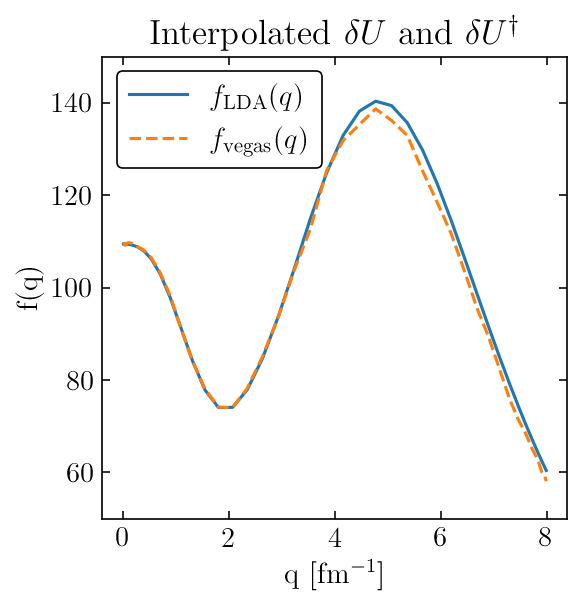

In [24]:
# Plot f_{LDA}(q) and f_{vegas}(q)
plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))
ax.plot(q_array, f_lda_array, label=r'$f_{\rm{LDA}}(q)$', linestyle='-')
ax.plot(q_array, f_vegas_array, label=r'$f_{\rm{vegas}}(q)$', linestyle='--')
ax.set_ylim((50.0, 150.0))
ax.set_xlabel(r'q [fm$^{-1}$]')
ax.set_ylabel('f(q)')
ax.legend(loc='upper left')
ax.set_title(r'Interpolated $\delta U$ and $\delta U^\dagger$')
plt.show()

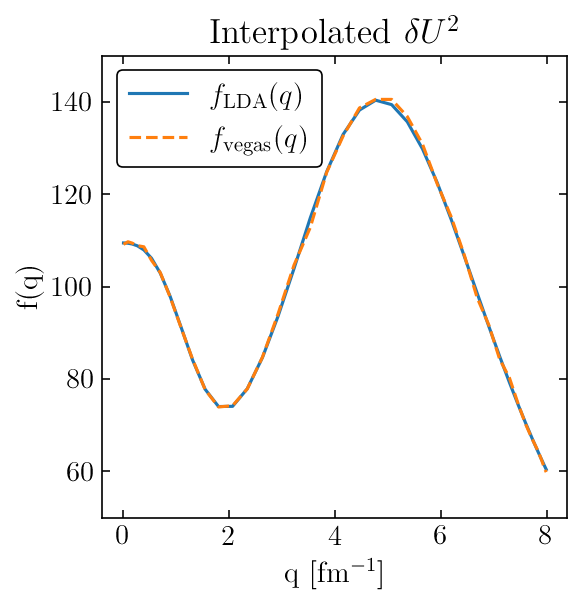

In [25]:
# Plot f_{LDA}(q) and f_{vegas}(q)
plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))
ax.plot(q_array, f_lda_array, label=r'$f_{\rm{LDA}}(q)$', linestyle='-')
ax.plot(q_array, f_vegas_sq_array, label=r'$f_{\rm{vegas}}(q)$', linestyle='--')
ax.set_ylim((50.0, 150.0))
ax.set_xlabel(r'q [fm$^{-1}$]')
ax.set_ylabel('f(q)')
ax.legend(loc='upper left')
ax.set_title(r'Interpolated $\delta U^2$')
plt.show()

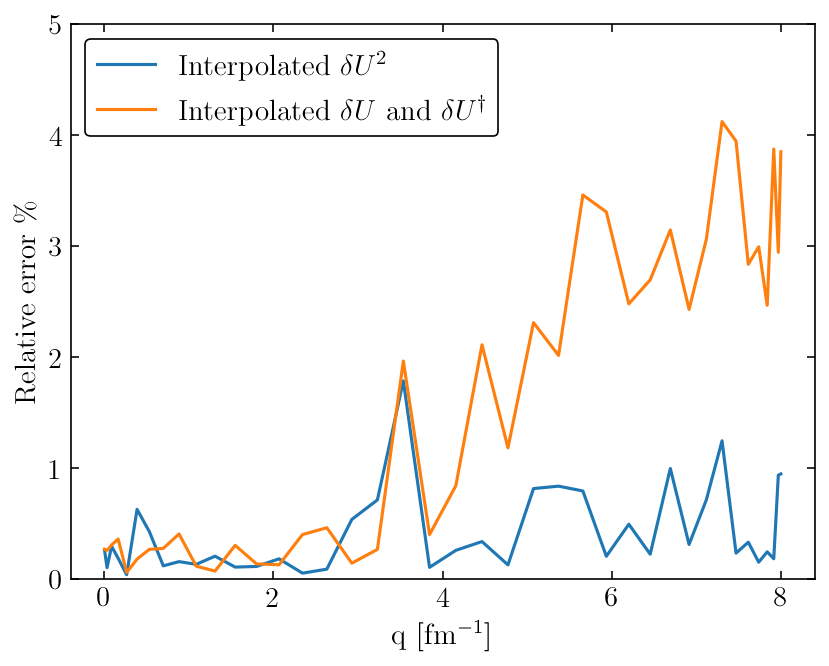

In [26]:
# Plot relative error of f_{LDA}(q) and f_{vegas}(q)
plt.plot(q_array, abs(f_lda_array-f_vegas_sq_array)/f_lda_array*100,
         label=r'Interpolated $\delta U^2$')
plt.plot(q_array, abs(f_lda_array-f_vegas_array)/f_lda_array*100,
         label=r'Interpolated $\delta U$ and $\delta U^\dagger$')
plt.xlabel(r'q [fm$^{-1}$]')
plt.ylabel('Relative error \%')
plt.ylim((0,5))
plt.legend()
plt.show()

In [27]:
def gq_function(
        q_array, K_array, K_weights, potential, channel, delta_U_functions,
        delta_U_dagger_functions
):
    """Computing f(q) as in the vegas expression using full Gaussian quadrature
    on the angular integrals as well."""
    
    k_array, k_weights = potential.load_mesh()
    theta_array, theta_weights = gaussian_quadrature_mesh(np.pi, 7)
    phi_array, phi_weights = gaussian_quadrature_mesh(2*np.pi, 13)
    
    k_grid, thetak_grid, phik_grid, K_grid, thetaK_grid, phiK_grid = (
        np.meshgrid(k_array, theta_array, phi_array, K_array, theta_array,
                    phi_array, indexing='ij')
    )
    dk_grid, dthetak_grid, dphik_grid, dK_grid, dthetaK_grid, dphiK_grid = (
        np.meshgrid(k_weights, theta_weights, phi_weights, K_weights,
                    theta_weights, phi_weights, indexing='ij')
    )
    
    jacobian_grid = (
        k_grid**2 * dk_grid * np.sin(thetak_grid) * dthetak_grid * dphik_grid
        * K_grid**2 * dK_grid * np.sin(thetaK_grid) * dthetaK_grid * dphiK_grid
    )
    
    # This gives the entire function (sum of functions) in square brackets
    _, _, deltaU2_func_lda = interpolated_delta_U_lda(potential, channel)
    
    # Loop over q
    t0 = time.time()
    f_gq_array = np.zeros_like(q_array)
    for iq, q in enumerate(q_array):
        
        # Choose z-axis to be along q_vector
        q_vector_grid = q * np.array([
            np.zeros_like(thetak_grid), np.zeros_like(thetak_grid),
            np.ones_like(thetak_grid)
        ])
        K_vector_grid = np.array([
            K_grid * np.sin(thetaK_grid) * np.cos(phiK_grid),
            K_grid * np.sin(thetaK_grid) * np.sin(phiK_grid),
            K_grid * np.cos(thetaK_grid)
        ])
        qK_grid = la.norm(q_vector_grid - K_vector_grid/2, axis=0)

        # Use interpolating function from old LDA code
        deltaU2_grid = deltaU2_func_lda.ev(k_grid, qK_grid)
        
#         # Use interpolating function from new code
#         deltaU2_grid = (
#             delta_U_functions['3S1-3S1'].ev(k_grid, qK_grid)
#             * delta_U_dagger_functions['3S1-3S1'].ev(qK_grid, k_grid)
#             + delta_U_functions['3S1-3D1'].ev(k_grid, qK_grid)
#             * delta_U_dagger_functions['3D1-3S1'].ev(qK_grid, k_grid)
#         )
        
        integrand = jacobian_grid * deltaU2_grid
        
        # Integrate over K_vector and k_vector
        f_gq_array[iq] = np.sum(
            np.sum(
                np.sum(
                    np.sum(
                        np.sum(
                            np.sum(integrand, axis=-1), axis=-1
                        ), axis=-1
                    ), axis=-1
                ), axis=-1
            ), axis=-1
        )
        
    t1 = time.time()
    mins = (t1-t0)/60
    print(f"Done after {mins:.3f} minutes.")
        
    return f_gq_array

In [28]:
f_gq_function = gq_function(q_array, K_array, K_weights, potential, channel,
                            delta_U_functions, delta_U_dagger_functions)

Done after 4.584 minutes.


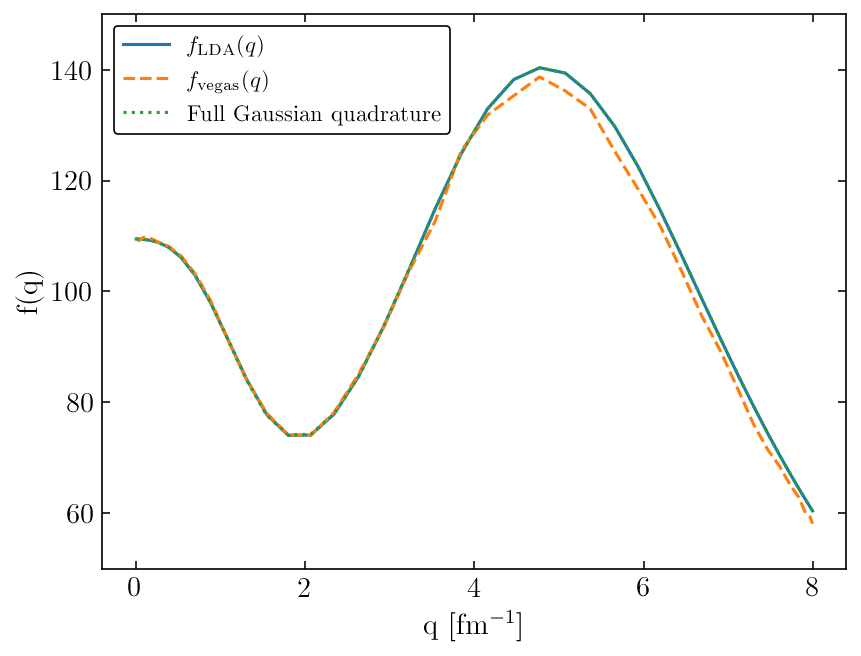

In [29]:
plt.plot(q_array, f_lda_array, label=r'$f_{\rm{LDA}}(q)$', linestyle='-')
plt.plot(q_array, f_vegas_array, label=r'$f_{\rm{vegas}}(q)$', linestyle='--')
plt.plot(q_array, f_gq_function, label='Full Gaussian quadrature',
         linestyle=':')
plt.ylim((50.0, 150.0))
plt.xlabel(r'q [fm$^{-1}$]')
plt.ylabel('f(q)')
plt.legend(fontsize=11, loc='upper left')
plt.show()

## Add in the spherical harmonics

### Try only $L=0$ first

In [30]:
# LDA function with angle-averaging -> f_{LDA}(q)
def lda_function_swaves():
    return None

In [31]:
# vegas sampling function with spherical harmonics -> f_{vegas}(q)
def vegas_function_swaves():
    return None

In [32]:
# Compare angle-averaging vs vegas sampling

# Plot f_{LDA}(q) and f_{vegas}(q)

### Add in $L > 0$ contributions

In [33]:
# LDA function with angle-averaging -> f_{LDA}(q)
def lda_function_full():
    return None

In [34]:
# vegas sampling function with spherical harmonics -> f_{vegas}(q)
def vegas_function_full():
    return None

In [35]:
# Compare angle-averaging vs vegas sampling

# Plot f_{LDA}(q) and f_{vegas}(q)

In [36]:
# If necessary, add in factors and CG's